<a href="https://colab.research.google.com/github/uribalb/PlacesRecommender/blob/master/EDA_DP/YelpUsersRestaurants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

review_restaurants = pd.read_csv('/content/drive/MyDrive/recommender_dataset/Yelp/yelp_dataset/yelp_review_restaurants_sentiment.csv')
df_users = pd.read_csv('/content/drive/MyDrive/recommender_dataset/Yelp/yelp_dataset/yelp_users.csv')
df_restaurants = pd.read_csv('/content/drive/MyDrive/recommender_dataset/Yelp/yelp_dataset/yelp_restaurants.csv')


In [ ]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             1125 non-null   object 
 1   name                1125 non-null   object 
 2   review_count        1125 non-null   int64  
 3   yelping_since       1125 non-null   object 
 4   useful              1125 non-null   int64  
 5   funny               1125 non-null   int64  
 6   cool                1125 non-null   int64  
 7   elite               316 non-null    object 
 8   friends             1125 non-null   object 
 9   fans                1125 non-null   int64  
 10  average_stars       1125 non-null   float64
 11  compliment_hot      1125 non-null   int64  
 12  compliment_more     1125 non-null   int64  
 13  compliment_profile  1125 non-null   int64  
 14  compliment_cute     1125 non-null   int64  
 15  compliment_list     1125 non-null   int64  
 16  compli

In [ ]:
df_restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   114 non-null    object 
 1   name          114 non-null    object 
 2   address       114 non-null    object 
 3   city          114 non-null    object 
 4   state         114 non-null    object 
 5   postal_code   114 non-null    object 
 6   latitude      114 non-null    float64
 7   longitude     114 non-null    float64
 8   stars         114 non-null    float64
 9   review_count  114 non-null    int64  
 10  is_open       114 non-null    int64  
 11  attributes    109 non-null    object 
 12  categories    114 non-null    object 
 13  hours         11 non-null     object 
dtypes: float64(3), int64(2), object(9)
memory usage: 12.6+ KB


In [35]:
df_restaurants.iloc[0]['attributes']

'{\'BusinessAcceptsCreditCards\': \'True\', \'RestaurantsDelivery\': \'False\', \'RestaurantsTakeOut\': \'False\', \'RestaurantsGoodForGroups\': \'True\', \'GoodForKids\': \'False\', \'RestaurantsPriceRange2\': \'3\', \'RestaurantsAttire\': "\'casual\'", \'BusinessParking\': "{\'garage\': False, \'street\': True, \'validated\': False, \'lot\': False, \'valet\': False}", \'Alcohol\': "u\'full_bar\'", \'RestaurantsReservations\': \'True\', \'OutdoorSeating\': \'True\'}'

In [ ]:
review_restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_id    1202 non-null   object 
 1   user_id      1202 non-null   object 
 2   business_id  1202 non-null   object 
 3   stars        1202 non-null   int64  
 4   useful       1202 non-null   int64  
 5   funny        1202 non-null   int64  
 6   cool         1202 non-null   int64  
 7   text         1202 non-null   object 
 8   date         1202 non-null   object 
 9   POSITIVE     1202 non-null   float64
 10  NEGATIVE     1202 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 103.4+ KB


<a id="ref3"></a>
<h2>The Restricted Boltzmann Machine model</h2>

<img src="https://i.imgur.com/tdFk1NH.png"  width="300">
<br>
The Restricted Boltzmann Machine model has two layers of neurons, one of which is what we call a visible input layer and the other is called a hidden layer. The hidden layer is used to learn features from the information fed through the input layer. For our model, the input is going to contain X neurons, where X is the amount of restaurants in our dataset. Each of these neurons will possess a normalized rating value varying from 0 to 1, where 0 meaning that a user has not gone to that restaurant and the closer the value is to 1, the more the user likes the restaurant that neuron's representing. These normalized values, of course, will be extracted and normalized from the ratings dataset, specifically the number of stars given to restaurants.

After passing in the input, we train the RBM on it and have the hidden layer learn its features. These features are what we use to reconstruct the input, which in our case, will predict the ratings for restaurant that a given user hasn't gone to.

We will now begin to format our dataset to follow the model's expected input.

In [3]:

# Merge DataFrames
combined_df = review_restaurants.merge(df_restaurants, on='business_id')
combined_df = combined_df.merge(df_users, on='user_id')


In [ ]:
combined_df.columns

Index(['review_id', 'user_id', 'business_id', 'stars_x', 'useful_x', 'funny_x',
       'cool_x', 'text', 'date', 'POSITIVE', 'NEGATIVE', 'name_x', 'address',
       'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars_y',
       'review_count_x', 'is_open', 'attributes', 'categories', 'hours',
       'name_y', 'review_count_y', 'yelping_since', 'useful_y', 'funny_y',
       'cool_y', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos'],
      dtype='object')

In [4]:

# Create rating matrix (or interaction matrix)
user_rating_df = combined_df.pivot_table(values='stars_x', index='user_id', columns='business_id')


In [ ]:
user_rating_df.head()

business_id,-PkchovDBosOtZx4XLatVw,-SGvS9V0Yc5Ler2HrgtYJw,0CennNWmhiYdSOEkGr7vkw,2INVBDZ45z4Tbg3VtdDyTg,2lzcB7p5YlBimh4vfr6Fpw,2s5h1TMhYPdRUUNcQFr3WA,3tTVN74KJAN0z1DJ_dsE6w,4IvQU16RBKuLtpgx8yLqmQ,4qie_VdA-vTitNFl36F9Pw,7IoEVMWgTFjjaYG02eQAsw,...,vb9VqzcTk3pUWuyWwTV0tg,vw-xE1CJ9fYRSPu9Iy9mdA,wEWy_NbtwcgNY2dKEmnACA,x2J-YIFeGZ-nsezzooVA9g,x2xQUz1YfOzy5A9FRuCpMw,xEoAXOgrUOh-M1NUp6-Kaw,yHtS6dj20tl3ht32w6K6Qw,yOAZ47U67aDUwDXMrnv8UQ,yezrPF5W9KBm-JI9ZeudNg,yhx1hIne1Wr-9v4EMdziRw
user_id,,,,,,,,,,,,,,,,,,,,,
--KsuCSkGGvDKTbdK9NvIg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-63BhPqs8Uf3YrXFo9jskg,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-B-QEUESGWHPE_889WJaeg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-GDdBOfhrxn7lAGblLSoqA,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-IJ70Lh1NZ0uXC66xM-tGA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
user_rating_df.fillna(0, inplace=True)
norm_user_rating_df = user_rating_df.fillna(0) / 5.0
trX = norm_user_rating_df.values
trX[0:5]

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0.6, 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.

In [6]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<a id="ref4"></a>
<h2>Setting the Model's Parameters</h2>

Next, let's start building our RBM with TensorFlow. We'll begin by first determining the number of neurons in the hidden layers and then creating placeholder variables for storing our visible layer biases, hidden layer biases and weights that connects the hidden layer with the visible layer. We will be arbitrarily setting the number of neurons in the hidden layers to experiment.

In [ ]:
# Variable definitions
hidden_units = 10
visible_units = len(user_rating_df.columns)
vb = tf.Variable(tf.zeros([visible_units]), dtype=tf.float32)
hb = tf.Variable(tf.zeros([hidden_units]), dtype=tf.float32)
W = tf.Variable(tf.random.normal([visible_units, hidden_units]), dtype=tf.float32)

We then move on to creating the visible and hidden layer units and setting their activation functions. In this case, we will be using the <code>tf.sigmoid</code> and <code>tf.relu</code> functions as nonlinear activations since it is commonly used in RBM's.

In [ ]:
# Phase 1: Input Processing
v0 = tf.Variable(tf.zeros([tf.shape(trX)[0], visible_units]), dtype=tf.float32)
_h0 = tf.keras.activations.sigmoid(tf.matmul(v0, W) + hb)
h0 = tf.keras.activations.relu(tf.sign(_h0 - tf.random.uniform(tf.shape(_h0))))

#Phase 2: Reconstruction
_v1 = tf.keras.activations.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb)
v1 = tf.keras.activations.relu(tf.sign(_v1 - tf.random.uniform(tf.shape(_v1))))
h1 = tf.keras.activations.sigmoid(tf.matmul(v1, W) + hb)

Now we set the RBM training parameters and functions.

In [ ]:
# Learning rate
alpha = 1e-4

# Contrastive Divergence
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
CD = (w_pos_grad - w_neg_grad) / tf.cast(tf.shape(v0)[0], tf.float32)

# Update rules
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, axis=0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, axis=0)


And set the error function, which in this case will be the Mean Absolute Error Function.

In [ ]:
# Error calculation
err = v0 - v1
err_sum = tf.reduce_mean(err * err)

Now we train the RBM with 15 epochs with each epoch using 10 batches with size 100. After training, we print out a graph with the error by epoch.

Epoch 1: Error = 0.49921247363090515
Epoch 2: Error = 0.49921247363090515
Epoch 3: Error = 0.49921247363090515
Epoch 4: Error = 0.49921247363090515
Epoch 5: Error = 0.49921247363090515
Epoch 6: Error = 0.49921247363090515
Epoch 7: Error = 0.49921247363090515
Epoch 8: Error = 0.49921247363090515
Epoch 9: Error = 0.49921247363090515
Epoch 10: Error = 0.49921247363090515
Epoch 11: Error = 0.49921247363090515
Epoch 12: Error = 0.49921247363090515
Epoch 13: Error = 0.49921247363090515
Epoch 14: Error = 0.49921247363090515
Epoch 15: Error = 0.49921247363090515
Epoch 16: Error = 0.49921247363090515
Epoch 17: Error = 0.49921247363090515
Epoch 18: Error = 0.49921247363090515
Epoch 19: Error = 0.49921247363090515
Epoch 20: Error = 0.49921247363090515
Epoch 21: Error = 0.49921247363090515
Epoch 22: Error = 0.49921247363090515
Epoch 23: Error = 0.49921247363090515
Epoch 24: Error = 0.49921247363090515
Epoch 25: Error = 0.49921247363090515
Epoch 26: Error = 0.49921247363090515
Epoch 27: Error = 0.4

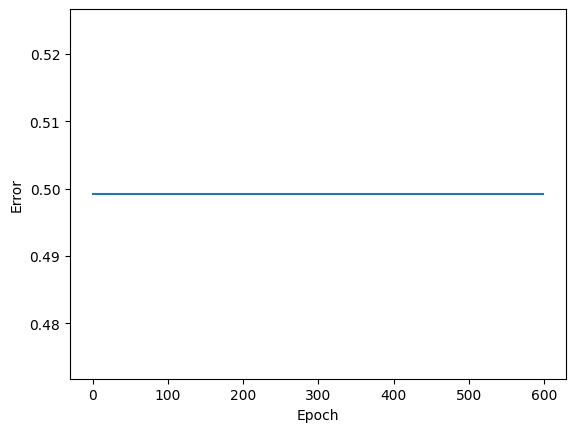

In [ ]:
# Training loop
epochs = 50
batch_size = 100
errors = []
for epoch in range(epochs):
    for start in range(0, len(trX), batch_size):
        end = min(start + batch_size, len(trX))
        batch = trX[start:end]

        # Update weights and biases using eager execution
        W.assign(update_w)
        vb.assign(update_vb)
        hb.assign(update_hb)


        errors.append(err_sum.numpy())

    print(f"Epoch {epoch+1}: Error = {errors[-1]}")

# Plot errors
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

The MSE doesn't change, which means that the training signal from our dataset is tenuous. We'll examine some hypotheses that might explain this result

In [ ]:
# Max number of ratings per user
np.count_nonzero(trX, axis=1).max()

4

In [ ]:
# Average number of ratings per user
np.count_nonzero(trX, axis=1).mean()

1.0373333333333334

In [31]:
from collections import Counter
unique_ratings_count = dict(Counter(np.count_nonzero(trX, axis=1)))
unique_ratings_count

{1: 1087, 2: 35, 3: 2, 4: 1}

The trX matrix of ratings is of shape (1125, 114) , so 1125 users rating 114 restaurants. Each user rated at most 4 restaurants and the average number of restaurants rated per user is barely above 1. In fact, an overwhelming majority of users rated only one restaurant.
The sparsity of the ratings matrix leads to an extremely sparse signal for the RBM, whose strength as a recommender model lies in the potential overlaps/similarities in user ratings across restaurants.  We conclude that a Restricted Boltzmann Machine might not be the right model in our case, since there is not enough "interactions" between users and restaurants

On the other hand:

In [32]:
dict(Counter(np.count_nonzero(trX.T, axis=1)))

{15: 1,
 56: 1,
 6: 13,
 8: 17,
 16: 2,
 13: 2,
 7: 16,
 12: 4,
 19: 3,
 23: 2,
 5: 21,
 25: 1,
 37: 1,
 9: 5,
 21: 1,
 10: 10,
 18: 2,
 11: 6,
 22: 3,
 17: 1,
 14: 1,
 29: 1}

### Training KNN-based algorithm to make use of user-user and restaurant-restaurant similarity

#### 1st approach: using user-based CF

In [7]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(metric='cosine', algorithm='brute')  # Adjust metric and algorithm if needed
knn.fit(trX)

NearestNeighbors(algorithm='brute', metric='cosine')

In [24]:
# Quick util to fill NaN
def fillna(arr):
    return np.where(np.isnan(arr), 0, arr)

arr = np.array([1, 2, np.NaN])
filled_arr = fillna(arr)
print(filled_arr)  # Output: [1 2 0]

[1. 2. 0.]


In [31]:
#Simple KNN-based recommendation

def similar_users_from_ratings(user_ratings, k=5, user_index=None):
    user_ratings = fillna(user_ratings)
    distances, indices = knn.kneighbors(user_ratings.reshape(1, -1), n_neighbors=k+1)
    nearest_neighbors = indices[0] if user_index==None else np.delete(indices[0], np.where(indices[0] == user_index))  # Exclude the user itself

    return user_rating_df.iloc[nearest_neighbors]

def similar_users_from_id(user_id, k=5):
    user_index = user_rating_df.index.get_loc(user_id)
    user_ratings = trX[user_index]
    return similar_users_from_ratings(user_ratings,k , user_index)


def recommend_restaurants_from_id_naive(user_id, n_sim=10):
  user_ids = similar_users_from_id(user_id, k=n_sim).idxmax(axis=1)
  return df_restaurants.loc[df_restaurants['business_id'].isin(user_ids)]

def recommend_restaurants_from_ratings_naive(user_ratings, n_sim=10):
  restaurants_ids=similar_users_from_ratings(user_ratings, k=n_sim).idxmax(axis=1)
  return df_restaurants.loc[df_restaurants['business_id'].isin(restaurants_ids)]


##### Example use

In [32]:
user_to_recommend = df_users.iloc[0]['user_id']  # Testing recommendations with actual user ID
df_users.loc[df_users['user_id'].isin(similar_users_from_id(user_to_recommend, k=10).index.values)]

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
52,BI4lPhrUpmEySIJUywjIjQ,Dee,1592,2005-07-08 15:21:37,2975,736,1460,"2006,2007,2008,2009,2010,2011,2012,2013","yApfpuLJmEYcXt_lpz_e8w, 4uqrXK9mECd6HsaSAV8_yA...",160,...,17,8,65,46,155,212,208,208,41,47
117,qunxFdBDVl0ordRJEPVNtQ,Lemonjelly,429,2007-04-06 21:36:06,1901,1317,1304,NaN,"NIgHMvhoSsP2nVT-AqVWNg, 5t8ySlAmpQS8P-xFYOu8Aw...",128,...,31,3,5,27,79,100,103,103,115,55
161,8Lc3-TTHjExd79GSQIHnAw,Christopher,627,2006-12-19 07:07:26,615,257,283,NaN,"uqY0yL_zKk-4CcOdEDJ-Ow, 3imjJmcsBveqpSdyTUY5UQ...",31,...,4,8,5,6,24,19,37,37,12,2
557,cs1GMqTt5eGmLqQyPijYcw,Jen,162,2006-06-15 23:14:05,268,214,147,"2006,2007","4ohEUObG716U9GNlMK7eNg, L2g6vS1GDfqLEpiDOFfCkA...",15,...,3,2,14,0,9,10,18,18,3,7
685,PSNakuyRt9i2TS1fz3pp_w,Angela,253,2007-10-09 16:34:18,252,64,70,"2009,2010","fvHiupqwrjwZ9GL8da6xtA, UVxY0iyPaqY7s4BSFtt-xA...",8,...,1,0,0,0,6,7,11,11,6,2
688,XJ5WJPLP-fTIFkza3ChGbA,Robbie,46,2007-04-03 15:06:24,35,18,22,NaN,"8hG50IvPBPpwVGA5HiZkHg, MGIfvuAcgbUtRnhWa_Jm2g...",4,...,0,0,0,0,1,4,4,4,0,0
929,WBmqTb2IrJu9_nIWgZu21g,Catherine,216,2006-02-20 20:43:59,378,101,207,"2006,2007,2008","huowshdRZBhpYV_7mCRM3Q, NZba-Q-Fp10iF77CTQt24Q...",23,...,4,4,3,0,14,27,31,31,10,2
932,WJnEifJRkI6bCH2iw8brFg,Nenette,576,2006-02-07 05:13:06,860,264,478,"2006,2007,2008,2009","umIYHRbXtyb_Yy5uThSD_A, wRGdmKC5Du-lxo01T06Fxg...",39,...,3,1,3,0,9,15,34,34,15,2
1045,J5aAT9bz6KQwfqosRuTt9w,Rebecca,108,2007-07-10 00:06:09,84,24,58,NaN,"57EebK4ybrj9uO3eBq1I3Q, xKD6xH0ga9KsMXDIwz2MCw...",2,...,1,0,1,0,3,5,8,8,4,2
1110,sugA1tq1RD1hflVQZvesIg,Enrique,500,2008-04-23 23:04:19,777,352,466,"2010,2011,2012,2013,2014,2015,2016,2017","Wx7cbLDqYEL3_aVZwh82Ww, mgE3Em0bbFewVaMrADoEHw...",50,...,7,6,0,1,20,53,64,64,37,5


In [33]:
recommend_restaurants_from_id_naive(user_to_recommend)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
109,QNoFrASBpqW8dzdAEIYjNQ,The Brown Pelican,2981 Cliff Dr,Santa Barbara,CA,93109,34.403821,-119.743656,4.0,11,0,"{'BusinessParking': ""{'garage': False, 'street...",Restaurants,NaN


##### Extending recommendations beyond best rated restaurant

In [34]:
import itertools

def flatten_n_times(data, n=1):
  if n == 0:
    return data
  result = []
  for item in data:
    if isinstance(item, list):
      result.extend(flatten_n_times(item, n - 1))
    else:
      result.append(item)
  return list(set(itertools.chain.from_iterable(result)))


def get_top_n_columns_list(df, n, column_labels='restaurants'):
  """
  This function takes a pandas DataFrame and an integer n as input and returns a new DataFrame with a single column containing a list of the top n column names with the highest values in each row.

  Args:
    df: A pandas DataFrame.
    n: An integer representing the number of top columns to return.

  Returns:
    A new pandas DataFrame with a single column named "Top N Columns" containing a list of the top n column names with the highest values in each row.
  """

  # Create a new DataFrame with a single column
  top_n_df = pd.DataFrame(columns=["Top " + str(n) + " " + column_labels])

  # Iterate through each row in the DataFrame
  for index, row in df.iterrows():
    # Sort the row in descending order based on its values
    sorted_row = row.sort_values(ascending=False)

    # Select the top n column names
    top_n_columns = sorted_row.index[:n].tolist()

    # Add the top n column names to the new DataFrame
    top_n_df.loc[index, "Top " + str(n) + " " + column_labels] = top_n_columns

  return top_n_df

def recommend_restaurants_from_id_top(user_id, n_sim=10, top_n=5):
  top_restaurants = flatten_n_times(get_top_n_columns_list(similar_users_from_id(user_id, k=n_sim), top_n).values.tolist())
  return df_restaurants.loc[df_restaurants['business_id'].isin(top_restaurants)]

def recommend_restaurants_from_ratings_top(user_ratings, n_sim=10, top_n=5):
  top_restaurants = flatten_n_times(get_top_n_columns_list(similar_users_from_ratings(user_ratings, k=n_sim), top_n).values.tolist())
  return df_restaurants.loc[df_restaurants['business_id'].isin(top_restaurants)]


In [30]:
recommend_restaurants_from_id_top(user_to_recommend)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
17,yHtS6dj20tl3ht32w6K6Qw,Stateside Restaurant & Lounge,1114 State St,Santa Barbara,CA,93190,34.423044,-119.703208,2.5,10,0,"{'BusinessParking': ""{'garage': False, 'street...",Restaurants,NaN
33,iLT6EshGvA9yMdLTqeIE_Q,Michael's Diner Restaurant,719 S Broadway,Pennsville,NJ,08070,39.611270,-75.501917,2.5,5,0,"{'Ambience': ""{'romantic': False, 'intimate': ...",Restaurants,"{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ..."
61,j9YvgjesIwLMCBGqDw4TUQ,Iguana Cafe,210 E Congress St,Tucson,AZ,85701,32.221883,-110.968308,3.0,13,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...",Restaurants,NaN
86,-PkchovDBosOtZx4XLatVw,Naceville Hotel,2038 Ridge Rd,Sellersville,PA,18960,40.351699,-75.372119,3.5,15,1,"{'Alcohol': ""u'full_bar'"", 'RestaurantsReserva...",Restaurants,NaN
103,eMAe0izoSWFxq8YIlpUREw,Coyote Crossing,102 Market Street,West Chester,PA,19382,39.960235,-75.603190,3.5,5,0,"{'RestaurantsPriceRange2': '3', 'RestaurantsRe...",Restaurants,NaN
107,i1pGM3unRHXWLr15yyeL9Q,Astral Plane,1708 Lombard Street,Philadelphia,PA,19146,39.945161,-75.170498,4.0,9,0,"{'RestaurantsGoodForGroups': 'True', 'Restaura...",Restaurants,NaN
109,QNoFrASBpqW8dzdAEIYjNQ,The Brown Pelican,2981 Cliff Dr,Santa Barbara,CA,93109,34.403821,-119.743656,4.0,11,0,"{'BusinessParking': ""{'garage': False, 'street...",Restaurants,NaN


#### 2nd approach: item-based CF

The approach is very similar to what we did in the previous chapter, except here we'll train the knn on the transpose of the ratings matrix


In [10]:
restaurant_rating_df = user_rating_df.T
restaurant_rating_df

user_id,--KsuCSkGGvDKTbdK9NvIg,-63BhPqs8Uf3YrXFo9jskg,-B-QEUESGWHPE_889WJaeg,-GDdBOfhrxn7lAGblLSoqA,-IJ70Lh1NZ0uXC66xM-tGA,-IoMd5brae24pyFRx13Phw,-J-ekA8rrhFV6jN5EvkLbg,-NDurCQ1u3CbUd05M7MaIA,-Oer2os7LrtAagVuWSN1AQ,-ZZ_ovaNT7EA1Fkokv44UQ,...,zOZR3F-fLi9oP5_PHFlqeQ,zUK5CQLSp_OVPpWDfeKAJQ,zUk_Ww2q1At1QSyRbUjIGQ,zflP2GbSos_x0vP_yCYZHg,zg23ChWAll3vAo5OGVRPyA,zj10N7YjZlgkVYup4xXwiQ,zkch2QUSC7zappMvdTvV0g,zrdkuuPFlNkLTSa9gMqbvQ,zux3SnpD2KSzYeCUlayGpw,zyNrXvJyYdC34tS6BcCykA
business_id,,,,,,,,,,,,,,,,,,,,,
-PkchovDBosOtZx4XLatVw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-SGvS9V0Yc5Ler2HrgtYJw,0.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0CennNWmhiYdSOEkGr7vkw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2INVBDZ45z4Tbg3VtdDyTg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2lzcB7p5YlBimh4vfr6Fpw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
xEoAXOgrUOh-M1NUp6-Kaw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yHtS6dj20tl3ht32w6K6Qw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yOAZ47U67aDUwDXMrnv8UQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
trY = trX.T
trY.shape

(114, 1125)

In [13]:
knn2 = NearestNeighbors(metric='cosine', algorithm='brute')  # Adjust metric and algorithm if needed
knn2.fit(trY)

NearestNeighbors(algorithm='brute', metric='cosine')

In [15]:
# Direct KNN-based recommendation

def similar_restaurants(restaurant_id, k=5):
    restaurant_index = restaurant_rating_df.index.get_loc(restaurant_id)
    restaurant_ratings = trY[restaurant_index]

    distances, indices = knn2.kneighbors(restaurant_ratings.reshape(1, -1), n_neighbors=k+1)
    nearest_neighbors = np.delete(indices[0], np.where(indices[0] == restaurant_index))  # Exclude the restaurant itself

    return df_restaurants.iloc[nearest_neighbors]


# def recommend_restaurants_naive(user_id, n_sim=10):
#   restaurants_ids=similar_users(user_id, k=n_sim).idxmax(axis=1)
#   return df_restaurants.loc[df_restaurants['business_id'].isin(restaurants_ids)]


##### Example use

In [16]:
user_to_recommend = df_users.iloc[0]['user_id']  # Testing recommendations with actual user ID
top_restaurant = user_rating_df.loc[user_to_recommend].idxmax()
top_restaurant

'QNoFrASBpqW8dzdAEIYjNQ'

In [135]:
similar_restaurants(top_restaurant)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
110,4IvQU16RBKuLtpgx8yLqmQ,Hunan Palace,6118 Lancaster Ave,Philadelphia,PA,19151,39.983388,-75.244222,4.5,7,1,"{'RestaurantsGoodForGroups': 'True', 'Restaura...",Restaurants,NaN
75,2s5h1TMhYPdRUUNcQFr3WA,California Cafe,160 N Gulph Rd,King of Prussia,PA,19406,40.089393,-75.386031,3.5,16,0,"{'OutdoorSeating': 'False', 'RestaurantsGoodFo...",Restaurants,"{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
77,d51ICeLySgnQhSRpWJC-pQ,Ventana Mexican Kitchen,"6875 E Sunrise Dr, #101",Tucson,AZ,85750,32.308862,-110.845496,2.0,5,0,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo...",Restaurants,"{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."
74,TxYxXvC5RcRRCYR6rbJgEQ,Aspen,747 N 25th St,Philadelphia,PA,19130,39.968780,-75.178154,4.0,7,0,"{'BusinessAcceptsCreditCards': 'True', 'Alcoho...",Restaurants,NaN
79,la8nNJ28dWLFwPUypxmqow,Burger King,3612 Lincoln Hwy,Coatesville,PA,19320,39.995366,-75.748162,1.5,6,0,"{'RestaurantsAttire': ""u'casual'"", 'Restaurant...",Restaurants,NaN
